In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [2]:
device = "mps"

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 16 * 16, 100)  # Adjust based on the input size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(100, 128 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = x.view(-1, 128, 16, 16)  # Reshape to match the encoder's last conv layer output shape
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # Use sigmoid for the last layer if images are normalized between [0,1]
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        losses = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            losses += loss.item()
            loss.backward()
            opt.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return autoencoder


In [5]:
num_epochs = 30
device = "mps"

class BoxingDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(directory, img) for img in os.listdir(directory)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor(),        # Convert images to PyTorch tensors
])

dataset = BoxingDataset(directory='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
autoencoder = Autoencoder().to(device)
autoencoder = train(autoencoder, dataloader, num_epochs)

Epoch 1, Loss: 1915.0721435546875
Epoch 2, Loss: 1089.6300048828125
Epoch 3, Loss: 725.9139404296875
Epoch 4, Loss: 554.4794311523438
Epoch 5, Loss: 496.4042053222656
Epoch 6, Loss: 444.9456787109375
Epoch 7, Loss: 424.80535888671875
Epoch 8, Loss: 374.1669921875
Epoch 9, Loss: 355.9107666015625
Epoch 10, Loss: 365.5966491699219


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(img):
    """
    Helper function to unnormalize and display an image
    """
    img = img / 2 + 0.5  # unnormalize if you used normalization in your transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_images(autoencoder, data_set, device):
    """
    Show original and reconstructed images.
    
    Parameters:
    - autoencoder: the trained autoencoder model.
    - data_loader: PyTorch DataLoader containing the dataset.
    - device: PyTorch device to use ('cuda' or 'cpu').
    """
    # Get a batch of images
    image = data_set[random.randint(0, len(data_set))]
    images = image.unsqueeze(0)

    print(images.max())

    # Move images to the device
    images = images.to(device)

    # Forward pass through the autoencoder
    reconstructed = autoencoder(images).detach()  # detach to avoid tracking history in autograd

    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Display original images
    print("Original Images")
    imshow(torchvision.utils.make_grid(images))

    # Display reconstructed images
    print("Reconstructed Images")
    imshow(torchvision.utils.make_grid(reconstructed))

tensor(0.8392)
Original Images


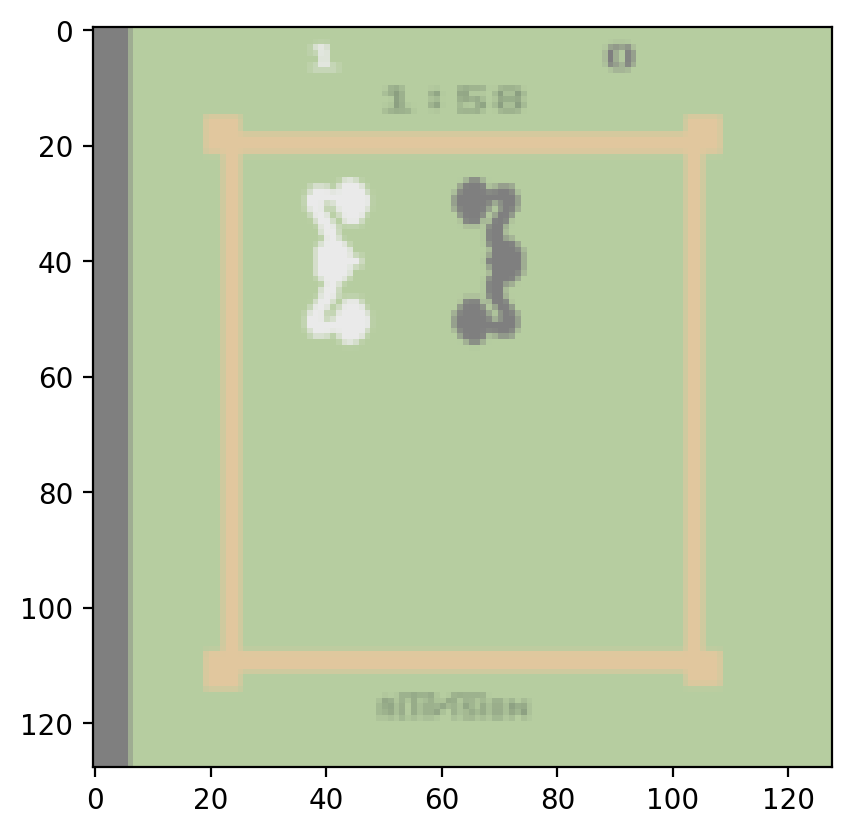

Reconstructed Images


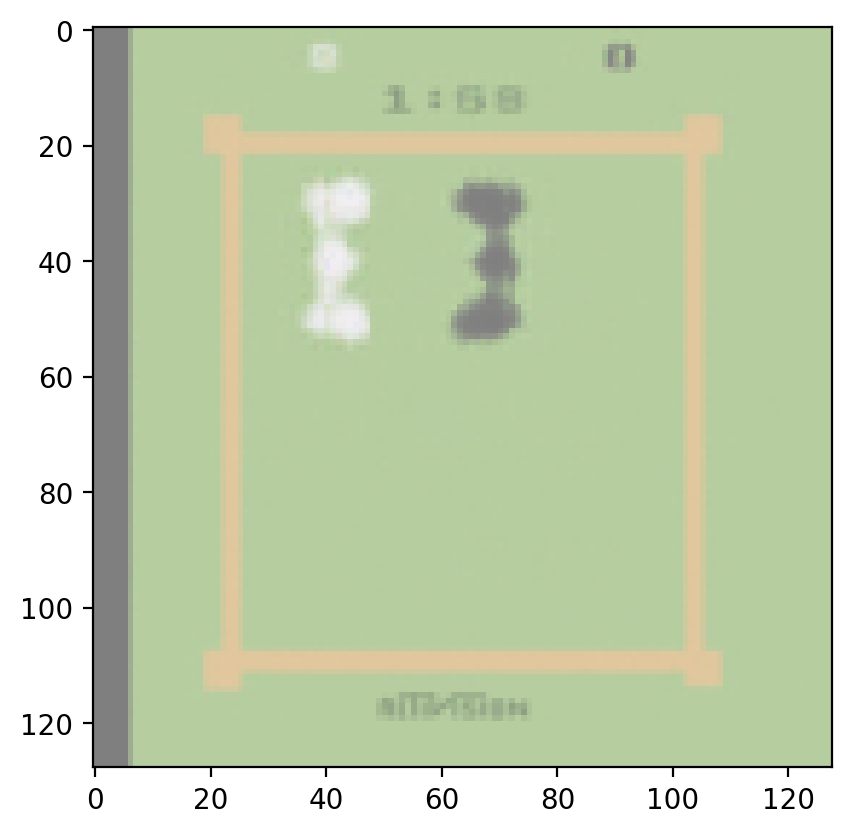

In [14]:
test_dataset = BoxingDataset(directory='images', transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=True)

show_images(autoencoder, test_dataset, device)

In [ ]:
torch.save(autoencoder.state_dict(), "models/autoencoder_100.pth")